In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
from progressbar import progressbar

In [2]:
import sys
from scipy.optimize import fsolve, root_scalar
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
# from Simulations.odeSolver.reversible.singleS import labels
from Simulations.odeSolver.doubleS import rxnNetwork as rxnDoubleS, labels as labelsDoubleS
from Simulations.odeSolver.singleS import rxnNetwork as rxnSingleS, labels as labelsSingleS
from Simulations.odeSolver.Nonly import rxnNetwork as rxnNonly, labels as labelsNonly
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

# Selectivity theory v.s. NERDSS

In [3]:
GenParms = lambda NP0, NS, scale, KPP: GenParameters(
    numTargets=NS, NP0=NP0, KPP=[KPP], KPN=[10], area3Dto1D=[10], lengthScale=scale, 
    kbPP_fixed=0.4, kaPN=0.02*1e6, kaPS=0.1*1e6
)
parms = GenParms([2,4], 2, 2, 10)

In [4]:
def freeProDiff(NP1, Ntot = 2, NS = 2, scale = 2, KPP = 1e6):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1])
    else:
        N1 = NP1
    
    if N1[0] < 1e-9:
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return -((Ntot-N1)*(1-theta2))[0]
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi1 = numericSolver(parm1, rxnSingleS, labelsSingleS, ifprint=False)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta1 = num.calc_BoundRatio_modelB(parm=parm1.iloc[0], equi=equi1.iloc[0])
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return (N1*(1-theta1) - (Ntot-N1)*(1-theta2))[0]
    
def pBoundRatios(NP1, Ntot = 2, NS = 2, scale = 2, KPP = 1e6):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1])
    else:
        N1 = NP1
    
    if N1[0] < 1e-9:
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return 0, theta2
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi1 = numericSolver(parm1, rxnSingleS, labelsSingleS, ifprint=False)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta1 = num.calc_BoundRatio_modelB(parm=parm1.iloc[0], equi=equi1.iloc[0])
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return theta1, theta2
    
def proteinsOnDNA(N1, Ntot, theta1, theta2):
    return theta1*(N1), theta2*(Ntot - N1)

In [5]:
KPPList = 10.0**np.arange(0,7.01,0.25)
clustered_onDNA = []
separated_onDNA = []
for i, Ptot in enumerate([2, 4]):
    spr_n = []
    cls_n = []
    for j in progressbar(range(len(KPPList))):
        kpp = KPPList[j]
        r_dimer = root_scalar(freeProDiff, x0=Ptot/2, x1=Ptot/2*0.9, xtol=1e-6, args=(Ptot, 2, 2, kpp))
        th1, th2 = pBoundRatios(r_dimer.root, Ptot, 2, 2, kpp)
        spr, cls = proteinsOnDNA(r_dimer.root, Ptot, th1, th2)
        cls_n.append(cls)
        spr_n.append(spr)
    clustered_onDNA.append(cls_n)
    separated_onDNA.append(spr_n)
clustered_onDNA = np.array(clustered_onDNA)
separated_onDNA = np.array(separated_onDNA)

100% (29 of 29) |########################| Elapsed Time: 0:00:26 Time:  0:00:26
100% (29 of 29) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


In [6]:
# NERDSS results
# raw data available while asking. msang2@jh.edu

slcList_repeats_2pro = [[0.7846134133371219, 1.1148256877425806, 3.226054260749391, 29.900123663086855, 189.86720995670993, 328.83102380952386, 716.3366904761904], 
                        [0.08059040750221995, 0.1138934291917021, 0.3452691124787163, 5.3201632313452265, 137.15285469713717, 249.43847606756407, 319.90795991151896]]
slcList_repeats_4pro =  [[0.7839380458445123, 1.608361702731444, 2.4142460159166124, 3.017057706286011, 2.75540309837026, 2.2933347821954073, 3.4153309304606063], 
                         [0.06433321086749408, 0.12193825141052676, 0.15954401742176008, 0.21645287528201054, 0.12229826213536317, 0.09116039107861558, 0.14586540127521788]]
slcList_repeats = [slcList_repeats_2pro, slcList_repeats_4pro]

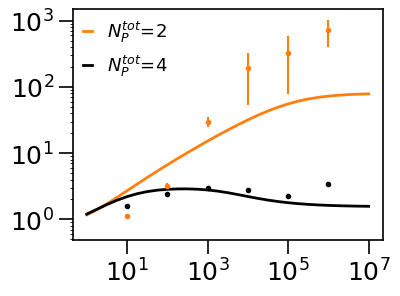

In [7]:
alphas = [1/3, 1]
colors = ['tab:orange', 'black']
plt.figure(figsize=(4,3))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)
    
for i, slcRepeat in enumerate(slcList_repeats):
    plt.errorbar(
        np.array([0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]), 
        slcRepeat[0], slcRepeat[1], 
        ls='', color=colors[i], marker='.', #edgecolors='black', alpha=alphas[1], 
    )
    
for i, ntot in enumerate([2, 4]):
    plt.plot(
        KPPList, ((clustered_onDNA/separated_onDNA))[i], ls='-', 
        label='$N_P^{tot}$=%d'%ntot, lw=2, color=colors[i], #color='tab:orange', alpha=alphas[i], 
        zorder=1,
    )


# plt.title('proteins on DNA', fontsize=13)
plt.legend(loc=[0.01,0.67], fontsize=13, handlelength=0.5, framealpha=0)
plt.loglog()
# plt.ylim([0.,1.01])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

# Selectivity - NERDSS spatial

Raw data availabel while asking. msang2@jh.edu

# Four DNA segments

In [8]:
# results from NERDSS simulations
targetCluster = np.array([1, 2, 3, 4])
figsize = (2.8,4)

import numpy as np
import scipy.stats as stats

def calculate_ttest_pvalue(mean1, se1, mean2, se2, n1=30, n2=30, equal_var=False):
    """
    Calculate t-test p-value from means and standard errors.
    
    Parameters:
    -----------
    mean1, mean2 : float
        Means of the two groups
    se1, se2 : float
        Standard errors of the two groups (can be from bootstrap)
    n1, n2 : int
        Original sample sizes of the two groups
    equal_var : bool, optional
        Whether to assume equal variances (default is False)
    
    Returns:
    --------
    dict
        Contains t-statistic, degrees of freedom, two-tailed p-value, 
        and 95% confidence interval for the difference
    """
    # Calculate mean difference
    mean_diff = mean2 - mean1
    
    # Calculate standard error of the difference
    se_diff = np.sqrt(se1**2 + se2**2)
    
    # Calculate t-statistic
    t_stat = mean_diff / se_diff
    
    # Calculate degrees of freedom
    if equal_var:
        # Pooled variance t-test
        df = n1 + n2 - 2
    else:
        # Welch-Satterthwaite approximation for degrees of freedom (unequal variances)
        df = ((se1**2 + se2**2)**2) / ((se1**4 / (n1-1)) + (se2**4 / (n2-1)))
    
    # Calculate two-tailed p-value
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))
    
    # Calculate 95% confidence interval
    t_critical = stats.t.ppf(0.975, df)  # 97.5th percentile for 95% CI
    margin = t_critical * se_diff
    ci_lower = mean_diff - margin
    ci_upper = mean_diff + margin
    
    return p_value


## Proteins can form dimers

In [9]:
# total protein number is 428
DNApartition_2 = ([1/428.        , 0.1932004 , 0.34046152, 0.43666561],
                 [1/428.        , 0.03428115, 0.02344495, 0.03153427])

In [10]:
for i in range(3):
    mu1 = DNApartition_2[0][i] / targetCluster[i]
    se1 = DNApartition_2[1][i] / targetCluster[i]
    mu2 = DNApartition_2[0][i+1] / targetCluster[i+1]
    se2 = DNApartition_2[1][i+1] / targetCluster[i+1]
    print(calculate_ttest_pvalue(mu1, se1, mu2, se2))

6.5036923793115875e-06
0.37531469873123235
0.6985274559220707


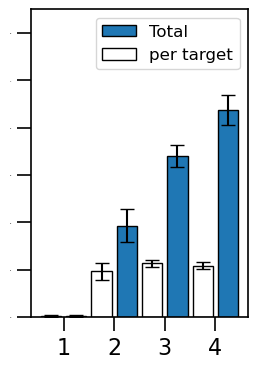

In [11]:
plt.figure(figsize=figsize)
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)

plt.bar(
    2*targetCluster, DNApartition_2[0], yerr=DNApartition_2[1],
    capsize=5, edgecolor='black', facecolor='tab:blue', label='Total'
)

plt.bar(
    2*targetCluster-1, DNApartition_2[0]/targetCluster, 
    yerr=DNApartition_2[1]/targetCluster,
    capsize=5, edgecolor='black', facecolor='none', label='per target'
)

plt.legend(fontsize=12)

plt.xticks(2*targetCluster-0.5, targetCluster, fontsize=16)
plt.yticks(fontsize=0)
plt.ylim([0., 0.65])
plt.show()

## monomer

In [12]:
DNApartition_1 = ([0.01963284, 0.04229797, 0.07063262, 0.0853417],
                 [0.00603037, 0.00844562, 0.00908131, 0.01204614])

In [13]:
for i in range(3):
    mu1 = DNApartition_1[0][i] / targetCluster[i]
    se1 = DNApartition_1[1][i] / targetCluster[i]
    mu2 = DNApartition_1[0][i+1] / targetCluster[i+1]
    se2 = DNApartition_1[1][i+1] / targetCluster[i+1]
    print(calculate_ttest_pvalue(mu1, se1, mu2, se2))

0.8376392063201665
0.6467004943373733
0.606926639098837


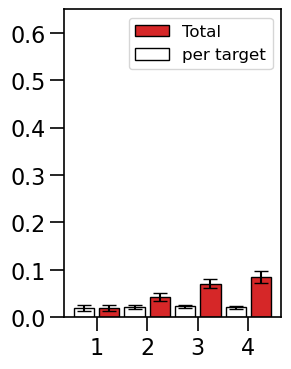

In [14]:
plt.figure(figsize=figsize)
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)

plt.bar(
    2*targetCluster, DNApartition_1[0], yerr=DNApartition_1[1],
    capsize=5, edgecolor='black', facecolor='tab:red', label='Total'
)

plt.bar(
    2*targetCluster-1, DNApartition_1[0]/targetCluster, 
    yerr=DNApartition_1[1]/targetCluster,
    capsize=5, edgecolor='black', facecolor='none', label='per target'
)

plt.legend(fontsize=12)

plt.xticks(2*targetCluster-0.5, targetCluster, fontsize=16)
plt.yticks(fontsize=16)
plt.ylim([0., 0.65])
plt.show()

## Linear tetramer

In [15]:
DNApartition_4 = ([1/396 , 0.08206282, 0.30460399, 0.54261452],
                 [1/396, 0.03363388, 0.06487353, 0.08738131])

In [16]:
for i in range(3):
    mu1 = DNApartition_4[0][i] / targetCluster[i]
    se1 = DNApartition_4[1][i] / targetCluster[i]
    mu2 = DNApartition_4[0][i+1] / targetCluster[i+1]
    se2 = DNApartition_4[1][i+1] / targetCluster[i+1]
    print(calculate_ttest_pvalue(mu1, se1, mu2, se2))

0.03086432216598789
0.03141021893738438
0.2715866700013434


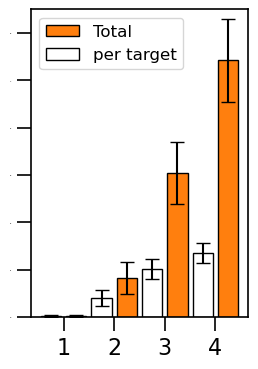

In [17]:
plt.figure(figsize=figsize)
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)

plt.bar(
    2*targetCluster, DNApartition_4[0], yerr=DNApartition_4[1],
    capsize=5, edgecolor='black', facecolor='tab:orange', label='Total'
)

plt.bar(
    2*targetCluster-1, DNApartition_4[0]/targetCluster, 
    yerr=DNApartition_4[1]/targetCluster,
    capsize=5, edgecolor='black', facecolor='none', label='per target'
)

plt.legend(fontsize=12)

plt.xticks(2*targetCluster-0.5, targetCluster, fontsize=16)
plt.yticks(fontsize=0)
plt.ylim([0., 0.65])

plt.show()